In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())
print(tf.version.VERSION)

for device in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

import sys
sys.version


C:\Users\Chanv\anaconda3\envs\tf2\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


Num GPUs Available:  1
True
2.10.1


'3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:28:38) [MSC v.1929 64 bit (AMD64)]'

In [2]:
DATASET_PATH = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train'
SINGLE_TEST_PATH = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Test/Test002'
BATCH_SIZE = 8
MODEL1_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/simpleAutoencoder2.hdf5"

In [3]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
import matplotlib.pyplot as plt

In [4]:
def evaluate(size, sequences, reconstructed_sequences):
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,size)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    mse = np.mean(np.square(sequences - reconstructed_sequences), axis=(1,2,3))

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

    return mse

In [5]:
def plot_mse_change(mse_values):

    # Create frame numbers starting from 1 to the length of MSE values
    frame_numbers = [x*10 for x in range(len(mse_values))]

    # Plot MSE against frame number
    plt.plot(frame_numbers, mse_values, marker='o', linestyle='-')
    plt.xlabel('Frame Number')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE Against Frame Number')
    plt.grid(True)
    plt.show()

In [6]:
import cv2
import os
import numpy as np

def preprocess_dataset(data_path, output_shape=(128, 128)):
    # Create a list to store preprocessed images
    preprocessed_data = []

    
    # Loop through each video sequence in the dataset
    for sequence_folder in os.listdir(data_path):
        sequence_path = os.path.join(data_path, sequence_folder)
        if sequence_path.endswith("Store"):
            continue
        print(sequence_path)
        
        frames = []
        # Read frames from the video sequence
        for frame_file in sorted(os.listdir(sequence_path)):
            if frame_file.endswith("Store"):
                continue
            
            if len(frames) == 10:
                preprocessed_data.append(frames)
                frames = []
           
            frame_path = os.path.join(sequence_path, frame_file)
            frame = cv2.imread(frame_path)
            frame = cv2.resize(frame, output_shape)  # Resize frame
            frame = frame.astype(np.float32) / 255.0  # Normalize pixel values
            frames.append(frame)
        preprocessed_data.append(frames)

    # Convert the list to a numpy array
    preprocessed_data = np.array(preprocessed_data)
    
    return preprocessed_data


# Path to the Ped2 dataset
data_path = DATASET_PATH

# Preprocess the Ped2 dataset
preprocessed_data = preprocess_dataset(data_path)


# Check the shape of the preprocessed data
print("Preprocessed dataset shape:", preprocessed_data.shape)


C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train001
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train002
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train003
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train004
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train005
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train006
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train007
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train008
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train009
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train010
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train011
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train012
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train013
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train014
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train015
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train016
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSD

In [7]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D

def get_model2(input_shape = (10, 128, 128, 3)):

    autoencoder = Sequential()

    # Encoder
    autoencoder.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    autoencoder.add(MaxPooling3D((1, 2, 2), padding='same'))
    autoencoder.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    autoencoder.add(MaxPooling3D((1, 2, 2), padding='same'))

    # Decoder
    autoencoder.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    autoencoder.add(UpSampling3D((1, 2, 2)))  # Upsampling to match original input shape
    autoencoder.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    autoencoder.add(UpSampling3D((1, 2, 2)))  # Upsampling to match original input shape
    autoencoder.add(Conv3D(3, (3, 3, 3), activation='sigmoid', padding='same'))  # Output RGB images

    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    return autoencoder

In [8]:
seq2 = get_model2()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 128, 128, 128  10496     
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 64, 64, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 64, 64, 64)    221248    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 10, 32, 32, 64)   0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 10, 32, 32, 64)    110656    
                                                        

In [9]:
from sklearn.model_selection import train_test_split

# Build autoencoder model
train_data, val_data = train_test_split(preprocessed_data, test_size=0.2, random_state=42)




In [10]:
from keras.models import load_model

# Train autoencoder
seq2.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-6))
# seq2.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=BATCH_SIZE)
# seq2.save(MODEL1_PATH)

seq2 = load_model(MODEL1_PATH)





# Testing

In [11]:
test_path = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Test/Test001'

In [12]:
def preprocess_test_dataset(data_path, output_shape=(128, 128)):
    # Create a list to store preprocessed images
    preprocessed_data = []
        
    # Read frames from the video sequence
    frames = []
    for frame_file in sorted(os.listdir(data_path)):
        
        if frame_file.endswith("Store"):
                continue
        
        if len(frames) == 10:
            preprocessed_data.append(frames)
            frames = []
        
        frame_path = os.path.join(data_path, frame_file)
        
        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, output_shape)  # Resize frame
        frame = frame.astype(np.float32) / 255.0  # Normalize pixel values
        
        frames.append(frame)
        
    preprocessed_data.append(frames)


    # Convert the list to a numpy array
    preprocessed_data = np.array(preprocessed_data)
    
    return preprocessed_data

test_data = preprocess_test_dataset(test_path)
print("Preprocessed dataset shape:", preprocessed_data.shape)

Preprocessed dataset shape: (150, 10, 128, 128, 3)


In [13]:
predicted_sequences = seq2.predict(test_data)

1/1 [==============================] - 5s 5s/step


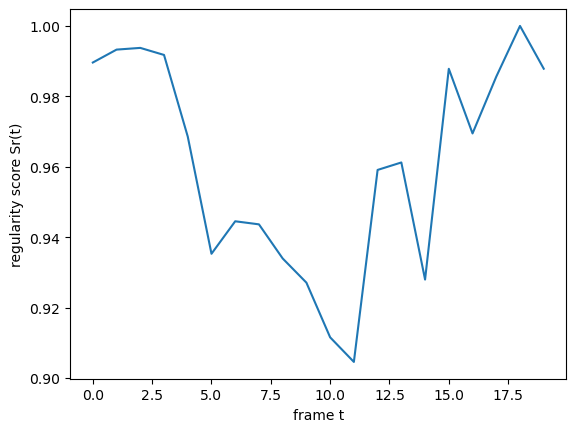

In [14]:
mse2 = evaluate(20, test_data, predicted_sequences)

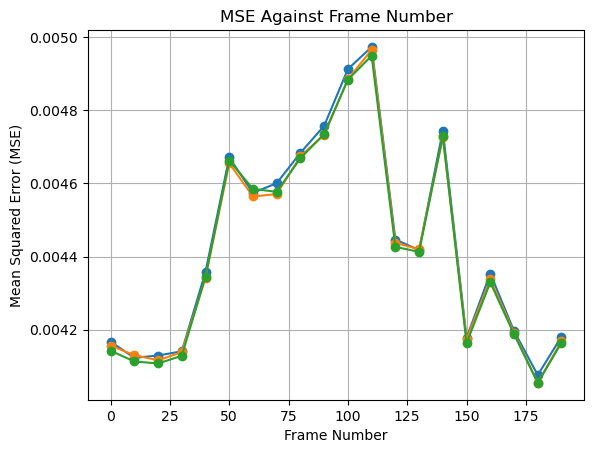

In [15]:
plot_mse_change(mse2)

In [16]:
print(mse2)

[[0.0041672  0.00415613 0.00414214]
 [0.00412274 0.00413015 0.00411291]
 [0.00412914 0.00411609 0.00410731]
 [0.00414055 0.00413815 0.00412831]
 [0.00435815 0.00434196 0.00434497]
 [0.00467124 0.00465524 0.00466262]
 [0.00457417 0.00456462 0.00458517]
 [0.00460082 0.00457088 0.00457714]
 [0.00468384 0.00467426 0.00466952]
 [0.00475787 0.00473362 0.00473515]
 [0.00491305 0.00488531 0.00488405]
 [0.0049738  0.00496592 0.00494973]
 [0.00444665 0.00443705 0.00442661]
 [0.00441766 0.00442041 0.00441276]
 [0.00474459 0.00472595 0.0047306 ]
 [0.00417747 0.00417356 0.00416312]
 [0.0043535  0.00433746 0.0043294 ]
 [0.00419634 0.00419162 0.00418725]
 [0.00407562 0.00405433 0.00405408]
 [0.0041807  0.00416845 0.00416432]]
